In [0]:
import torch
import torch.nn as nn
import os
import numpy as np
import random
from scipy import integrate

In [0]:
torch.autograd.set_detect_anomaly(True)
# Model for Recurrent Marked Temporal Point Process. Based on
# Nan, Du et al Recurrent Marked Temporal Point Processes: Embedding Event
# History to Vector.
# This is a pytorch implementation of his model
class RMTPP(nn.Module):
    # input type_dim: dimension of types, which is a one-hot representation
    # input hidden_dim: dimension of the hidden layer. Default is 1.
    # input n_layers: number of hidden layers. Default is 1.
    # This will initialize the recurrent neural network.
    def __init__(self, type_dim, hidden_dim=1, n_layers=1):
        super(RMTPP,self).__init__()
        self.type_dim = type_dim
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        # linear embedding layer: map from one-hot types to a number.
        self.type_emb = nn.Linear(self.type_dim, 1, bias=True)
        # recurrence layer: use of relu function, and the input are time and type
        self.rnn = nn.RNN(input_size=2, hidden_size=self.hidden_dim, num_layers=self.n_layers,
                          nonlinearity='relu', bias=True, batch_first=True)
        # type generation layer: map from hidden layers to a vector representation of types
        self.type_gen = nn.Linear(self.hidden_dim, self.type_dim, bias=True)
        # time generation layers: map time and hidden layers to generate time
        self.time_linear = nn.Linear(self.hidden_dim+1, 1, bias=True)

    # This is the forward step of neural network
    # Assume both the input has dim(batch, times, features) of dimension 3
    # input whole_time_info: all of the time information
    # input marker_info: training information for marker
    def forward(self, train_time, marker_info):
        marker1 = self.type_emb(marker_info)
        combi_inputs = torch.cat((train_time, marker1), dim=-1)
        out, hidden = self.rnn(combi_inputs)
        out1 = out.contiguous().view(-1, self.hidden_dim)
        type_guess = self.type_gen(out1)
        return type_guess, out

In [0]:
def train(model, device, whole_time_info, event_type, n_features,lr=0.01, n_epochs=1000):
    for parameter in model.parameters():
        parameter.data.fill_(random.uniform(-0.1,0.1))
    marker_info, marker_target, whole_marker = type_encode(event_type, n_features)
    train_time, whole_time_info = time_encode(whole_time_info)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    for epoch in range(1, n_epochs+1):
        optimizer.zero_grad()
        train_time.to(device)
        marker_info.to(device)
        type_out, hidden_out = model(train_time, marker_info)
        marker_target = torch.reshape(marker_target, (-1,))
        time_diff = whole_time_info[:, 1:, :] - whole_time_info[:, :-1, :]
        combi_input_time = torch.cat((hidden_out, time_diff), dim=-1)
        cif = model.time_linear(combi_input_time)
        hidden_out = torch.reshape(hidden_out, (-1, model.hidden_dim))
        cif = torch.reshape(cif,(-1, 1))
        cif_weight = list(model.time_linear.parameters())
        loss = criterion(type_out, marker_target) + my_loss(cif, cif_weight, hidden_out)
        loss.backward()
        optimizer.step()
        if epoch%10 == 0:
            print("Loss: {}".format(loss.item()))


def my_loss(cif, cif_weight, hidden_out):
    loss = torch.sum(cif+torch.exp(torch.mm(hidden_out,cif_weight[0][:,:-1].transpose(0,1))
                         + cif_weight[1][0])/cif_weight[0][0][-1]-torch.exp(cif)/cif_weight[0][0][-1])

    return -loss


def type_encode(event_type, numb_features):
    event_type_arr = np.array(event_type)
    type_s =np.zeros((len(event_type_arr), len(event_type_arr[0]), numb_features), dtype=np.float32)
    for i in range(len(event_type_arr)):
        for j in range(len(event_type_arr[0])):
            type_s[i][j][event_type_arr[i][j]] = 1
    type_s = torch.from_numpy(type_s)
    return type_s[:,:-1,:], torch.tensor(event_type_arr)[:,1:], type_s


def time_encode(time):
    time_info = np.zeros((len(time), len(time[0]), 1), dtype=np.float32)
    for i in range(len(time)):
        for j in range(len(time[i])):
            time_info[i][j][0] = time[i][j]
    time_for_train = torch.from_numpy(time_info[:, :-1, :])
    whole_time = torch.from_numpy(time_info)
    return time_for_train, whole_time


def make_time_target(time_sample):
    time_target = torch.zeros(len(time_sample), len(time_sample[0]))
    return time_target


def predict(model, device, time, marker, n_features):
    time = [time]
    marker = [marker]
    time_input = time_encode(time)[1]
    type_input = type_encode(marker, n_features)[2]
    type_input.to(device)
    time_input.to(device)
    type_out, hidden_out = model(time_input, type_input)
    type_out = nn.functional.softmax(type_out[-1], dim=0)
    type_int = torch.max(type_out, dim=0)[1].item()
    estimated_time = cal_integral(model, hidden_out[0][-1][0], time_input[0][-1][0])
    return type_int, estimated_time


def cal_integral(model, hidden_out, time):
    hidden_out = hidden_out.item()
    parameters = list(model.time_linear.parameters())
    bias = parameters[1][0].item()
    v = parameters[0][0][0].item()
    w = parameters[0][0][1].item()
    func = lambda x: equation(x, time, hidden_out, bias, v, w)
    y = integrate.quad(func, time, np.inf)
    return y[0]


def equation(time_var, start_time, hidden_out, bias, v, w):
    time_guess = time_var*np.exp(v*hidden_out + w*(time_var-start_time)
                                 + bias+np.exp(v*hidden_out+bias)/w
                                 - np.exp(v*hidden_out + w*(time_var-start_time)+bias)/w)
    return time_guess


def select_device():
    if torch.cuda.is_available():
        device = torch.device('cuda')
        print("You are using GPU acceleration.")
        print("Number of CUDAs(cores): ", torch.cuda.device_count())
    else:
        device = torch.device("cpu")
        print("CUDA is not Available. You are using CPU only.")
        print("Number of cores: ", os.cpu_count())
    return device


def data_process(file_name):
    f = open(file_name,'r')
    time_data = []
    file_data = f.readlines()
    f.close()
    for line in file_data:
        data = line.split(" ")
        a_list = []
        for i in range(len(data)):
            if data[i] != "\n":
                a_list.append(float(data[i]))
        time_data.append(a_list)
    return time_data


def generate_type(time_data):
    type_data = []
    for line in time_data:
      new_line = []
      for item in line:
          new_line.append(1)
      type_data.append(new_line)
    return type_data

In [62]:
time_data = data_process("time-train.txt")
type_data = generate_type(time_data)
model = RMTPP(2)
device = select_device()
train(model, device, time_data, type_data, 2, n_epochs=1000)

You are using GPU acceleration.
Number of CUDAs(cores):  1
Loss: 17437.712890625
Loss: 10511.39453125
Loss: 3677.794189453125
Loss: -2928.800048828125
Loss: -9239.0078125
Loss: -15138.7001953125
Loss: -20689.84765625
Loss: -26296.38671875
Loss: -31094.5078125
Loss: -35297.75
Loss: -38989.65625
Loss: -42201.8125
Loss: -44954.79296875
Loss: -47271.50390625
Loss: -49179.66015625
Loss: -50715.48046875
Loss: -51922.21484375
Loss: -52846.546875
Loss: -53534.87890625
Loss: -54033.3671875
Loss: -54383.78125
Loss: -54622.66796875
Loss: -54780.9375
Loss: -54883.296875
Loss: -54948.03125
Loss: -54987.671875
Loss: -55011.59765625
Loss: -55025.625
Loss: -55033.796875
Loss: -55038.74609375
Loss: -55041.8828125
Loss: -55043.9453125
Loss: -55045.66015625
Loss: -55047.109375
Loss: -55048.26171875
Loss: -55049.78125
Loss: -55051.0390625
Loss: -55052.28125
Loss: -55053.62890625
Loss: -55054.89453125
Loss: -55056.26171875
Loss: -55057.75390625
Loss: -55059.02734375
Loss: -55060.50390625
Loss: -55062.05859

In [70]:
torch.save(model, "model.pt")

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type RMTPP. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [0]:
model = torch.load("model.pt")

In [63]:
time_data = data_process("time-test.txt")
type_data = generate_type(time_data)
time_data = time_data[0][0:56]
type_data = type_data[0][0:56]
device = select_device()
for i in range(100):
  pred_type, pred_time = predict(model, device, time_data, type_data, 2)
  time_data.append(pred_time)
  type_data.append(pred_type)

You are using GPU acceleration.
Number of CUDAs(cores):  1


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:87: RuntimeWarning: overflow encountered in exp
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:80: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.


In [77]:
print(type_data)

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [78]:
print(time_data[55:])

[10.7141071618, 10.913673260273455, 11.113239446732196, 11.312805256060827, 11.512370697256241, 11.711936451266286, 11.911501342332627, 12.111066605743169, 12.310632010067888, 12.510197264535384, 12.709763082492131, 12.909328896609559, 13.108893730582944, 13.308458567881356, 13.508023458141153, 13.707587908539477, 13.907153169993366, 14.106718026284085, 14.30628293231913, 14.5058472636904, 14.705411627178606, 14.90497652672333, 15.10454138251613, 15.30410640430752, 15.50367104334718, 15.703233868031827, 15.902798161316024, 16.102350299049615, 16.301916478274237, 16.5014824334493, 16.701046128089285, 16.900611653780604, 17.100177492758885, 17.299743776100154, 17.49930818315491, 17.69887358304758, 17.898437715617096, 18.098003311104254, 18.297568729119867, 18.497134487783136, 18.69669933596674, 18.89626475172682, 19.095829150486956, 19.295394005801658, 19.494958901729117, 19.694523734143225, 19.8940882937542, 20.09365405072557, 20.293218032896313, 20.492783966946394, 20.69234915497717, 2

In [0]:
difference = []
for j in range(55,155):
    difference.append(time_data[j+1]-time_data[j])

In [0]:
from sklearn.metrics import mean_squared_error
from math import sqrt

In [0]:
time_data_origin = data_process("time-test.txt")

In [82]:
print(sqrt(mean_squared_error(time_data[55:], time_data_origin[0][55:])))

0.3264376927522263


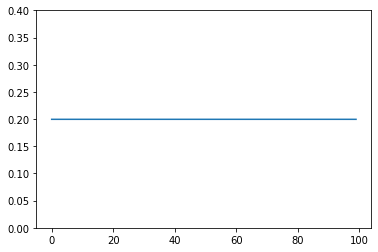

In [91]:
import matplotlib.pyplot as plt
plt.plot(range(100),difference)
plt.ylim(top=0.4, bottom=0.0)
plt.show()

In [84]:
print(difference)

[0.19956609847345597, 0.1995661864587408, 0.19956580932863055, 0.1995654411954142, 0.19956575401004528, 0.19956489106634123, 0.19956526341054115, 0.19956540432471925, 0.19956525446749573, 0.19956581795674744, 0.19956581411742746, 0.1995648339733851, 0.19956483729841246, 0.19956489025979707, 0.1995644503983236, 0.19956526145388942, 0.19956485629071885, 0.19956490603504484, 0.1995643313712705, 0.1995643634882054, 0.19956489954472367, 0.1995648557928007, 0.1995650217913898, 0.19956463903966082, 0.19956282468464615, 0.19956429328419745, 0.19955213773359048, 0.19956617922462172, 0.19956595517506415, 0.19956369463998413, 0.19956552569131958, 0.1995658389782804, 0.19956628334126947, 0.19956440705475487, 0.19956539989266986, 0.19956413256951677, 0.19956559548715802, 0.199565418015613, 0.19956575866326887, 0.19956484818360565, 0.19956541576008036, 0.19956439876013476, 0.19956485531470136, 0.19956489592745896, 0.19956483241410794, 0.19956455961097674, 0.19956575697136714, 0.19956398217074423, 0.